In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

Path('figures').mkdir(exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Benchmark names
benchmarks = ['HellaSwag', 'ARC-Easy', 'ARC-Challenge', 'WinoGrande', 'MMLU']

# Best tuned results
results = {
    'Teacher (FP16)': [0.526, 0.831, 0.557, 0.684, 0.707],
    'PTQ INT4': [0.509, 0.816, 0.527, 0.674, 0.678],
    'Off-policy (tuned)': [0.517, 0.824, 0.538, 0.688, 0.682],  # λ=0, β=0, lr=5e-6
    'On-policy (tuned)': [0.513, 0.821, 0.531, 0.690, 0.684],   # λ=1, β=1, lr=5e-6
}

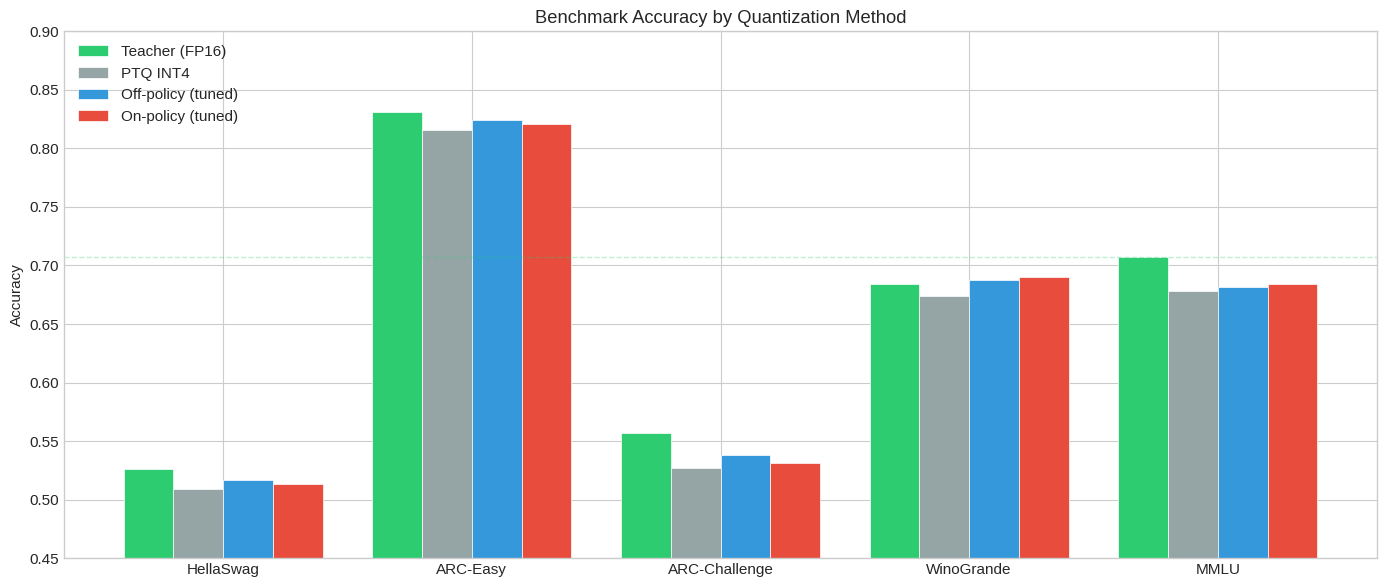

In [2]:
# Graph 1: Main Comparison - Teacher vs PTQ vs Distilled
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(benchmarks))
width = 0.2
colors = ['#2ecc71', '#95a5a6', '#3498db', '#e74c3c']  # green, gray, blue, red

for i, (model, scores) in enumerate(results.items()):
    offset = (i - 1.5) * width
    bars = ax.bar(x + offset, scores, width, label=model, color=colors[i], edgecolor='white', linewidth=0.5)

ax.set_ylabel('Accuracy')
ax.set_title('Benchmark Accuracy by Quantization Method')
ax.set_xticks(x)
ax.set_xticklabels(benchmarks)
ax.legend(loc='upper left')
ax.set_ylim(0.45, 0.9)

# Add horizontal line at teacher MMLU for reference
ax.axhline(y=0.707, color='#2ecc71', linestyle='--', alpha=0.3, linewidth=1)

plt.tight_layout()
plt.savefig('figures/main_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

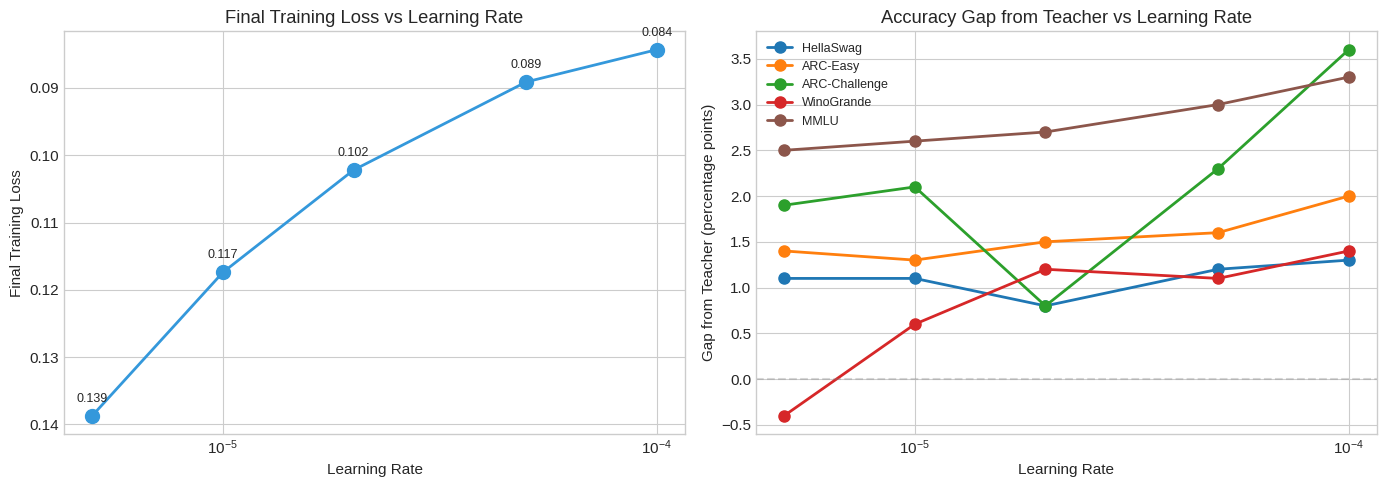

In [3]:
# Graph 2: LR Sweep - Train Loss vs Accuracy Gap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LR sweep data
lrs = [5e-6, 1e-5, 2e-5, 5e-5, 1e-4]
lr_labels = ['5e-6', '1e-5', '2e-5', '5e-5', '1e-4']

# Final train loss from new.csv
train_loss = [0.1387, 0.1174, 0.1022, 0.0891, 0.0843]

# Accuracy data
lr_accuracy = {
    'HellaSwag': [0.515, 0.515, 0.518, 0.514, 0.513],
    'ARC-Easy': [0.817, 0.818, 0.816, 0.815, 0.811],
    'ARC-Challenge': [0.538, 0.536, 0.549, 0.534, 0.521],
    'WinoGrande': [0.688, 0.678, 0.672, 0.673, 0.670],
    'MMLU': [0.682, 0.681, 0.680, 0.677, 0.674],
}

# Teacher baselines
teacher = {'HellaSwag': 0.526, 'ARC-Easy': 0.831, 'ARC-Challenge': 0.557,
           'WinoGrande': 0.684, 'MMLU': 0.707}

# Left panel: Train loss vs LR
ax = axes[0]
ax.plot(lrs, train_loss, 'o-', color='#3498db', markersize=10, linewidth=2)
for i, (lr, loss) in enumerate(zip(lrs, train_loss)):
    ax.annotate(f'{loss:.3f}', (lr, loss), textcoords='offset points',
                xytext=(0, 10), ha='center', fontsize=9)
ax.set_xscale('log')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Final Training Loss')
ax.set_title('Final Training Loss vs Learning Rate')
ax.invert_yaxis()  # Lower loss at bottom feels more intuitive

# Right panel: Accuracy gap from teacher
ax = axes[1]
colors = plt.cm.tab10(np.linspace(0, 0.5, 5))
for i, (bench, accs) in enumerate(lr_accuracy.items()):
    gap = [(teacher[bench] - acc) * 100 for acc in accs]  # percentage points
    ax.plot(lrs, gap, 'o-', label=bench, color=colors[i], markersize=8, linewidth=2)

ax.set_xscale('log')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Gap from Teacher (percentage points)')
ax.set_title('Accuracy Gap from Teacher vs Learning Rate')
ax.legend(loc='upper left', fontsize=9)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/lr_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

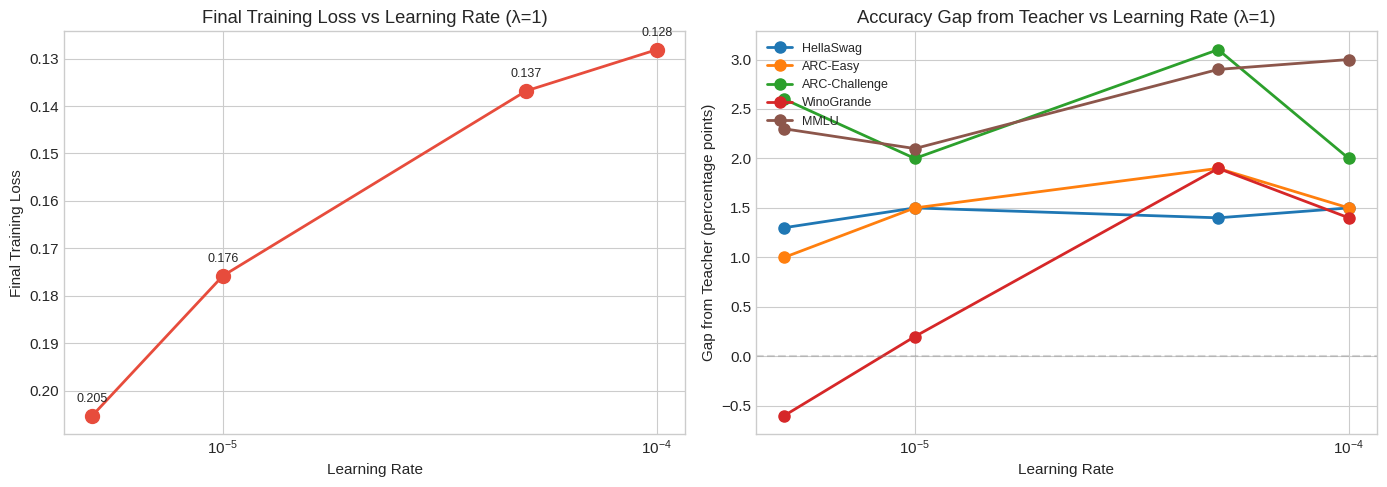

In [4]:
# Graph 3: LR Sweep for λ=1 (On-Policy)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LR sweep data for λ=1
lrs_lmbda1 = [5e-6, 1e-5, 5e-5, 1e-4]

# Final train loss from wandb
train_loss_lmbda1 = [0.2053, 0.1758, 0.1368, 0.1281]

# Accuracy data from training results
lr_accuracy_lmbda1 = {
    'HellaSwag': [0.513, 0.511, 0.512, 0.511],
    'ARC-Easy': [0.821, 0.816, 0.812, 0.816],
    'ARC-Challenge': [0.531, 0.537, 0.526, 0.537],
    'WinoGrande': [0.690, 0.682, 0.665, 0.670],
    'MMLU': [0.684, 0.686, 0.678, 0.677],
}

# Teacher baselines
teacher = {'HellaSwag': 0.526, 'ARC-Easy': 0.831, 'ARC-Challenge': 0.557,
           'WinoGrande': 0.684, 'MMLU': 0.707}

# Left panel: Train loss vs LR
ax = axes[0]
ax.plot(lrs_lmbda1, train_loss_lmbda1, 'o-', color='#e74c3c', markersize=10, linewidth=2)
for lr, loss in zip(lrs_lmbda1, train_loss_lmbda1):
    ax.annotate(f'{loss:.3f}', (lr, loss), textcoords='offset points',
                xytext=(0, 10), ha='center', fontsize=9)
ax.set_xscale('log')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Final Training Loss')
ax.set_title('Final Training Loss vs Learning Rate (λ=1)')
ax.invert_yaxis()

# Right panel: Accuracy gap from teacher
ax = axes[1]
colors = plt.cm.tab10(np.linspace(0, 0.5, 5))
for i, (bench, accs) in enumerate(lr_accuracy_lmbda1.items()):
    gap = [(teacher[bench] - acc) * 100 for acc in accs]  # percentage points
    ax.plot(lrs_lmbda1, gap, 'o-', label=bench, color=colors[i], markersize=8, linewidth=2)

ax.set_xscale('log')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Gap from Teacher (percentage points)')
ax.set_title('Accuracy Gap from Teacher vs Learning Rate (λ=1)')
ax.legend(loc='upper left', fontsize=9)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/lr_sweep_lmbda1.png', dpi=150, bbox_inches='tight')
plt.show()